In this tutorial we introduce and discuss basic, but key, concepts related to data sampling. In particular, we discuss uniform random sampling, the concept of diversity and representativeness. We consider a scenario in which fe have a finite set of data locations in a d-dimensional space (we fix d=2).   

In [2]:
#%pip install PAsampling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PAsampling import *

We consider a synthetic dataset consisting of 150 uniformly distributed points in the unit square, one cluster of 650 normally distributed points with a mean of [0.5, 0.5] (center of the unit square) and a standard deviation of 0.01, and one additional cluster with 200 normally distributed points with a mean of [0.15, 0.15] (lower-left corner of the unit square) and a standard deviation of 0.02. This synthetic dataset has points distributed across the unit square, but the majority of the points cluster at the center of the unit square and there is one additional cluster in the lower left corner (see plot blow)

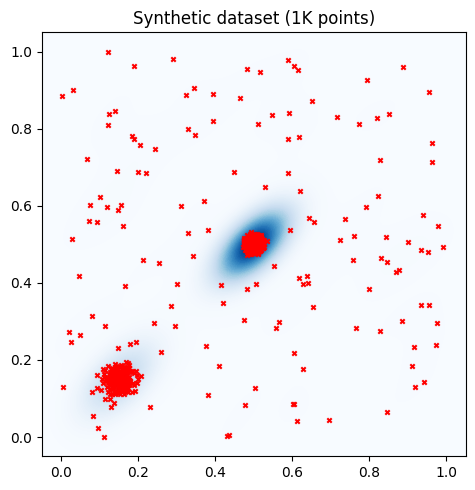

In [3]:
np.random.seed(23)

# Create synthetic dataset
uniform_points = np.random.rand(150, 2)  # 150 uniformly distributed points
mean, std_dev = [0.5, 0.5], 0.01  # Center and standard deviation for the first normal distribution
normal_points = np.random.normal(loc=mean, scale=std_dev, size=(650, 2))  # 650 normally distributed points
normal_points = np.clip(normal_points, 0, 1)  # Ensure points remain within the unit square [0, 1]
mean2, std_dev2 = [0.15, 0.15], 0.02  # Center and standard deviation for the second normal distribution
normal_points2 = np.random.normal(loc=mean2, scale=std_dev2, size=(200, 2))  # 200 normally distributed points
normal_points2 = np.clip(normal_points2, 0, 1)  # Ensure points remain within the unit square [0, 1]

# Combine and shuffle points
dataset = np.vstack((uniform_points, normal_points, normal_points2))
np.random.shuffle(dataset)

# Plot synthetic dataset 
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
titles = ['Synthetic dataset (1K points)']
data = [(dataset[:, 0], dataset[:, 1])]
sns.kdeplot(x=dataset[:, 0], y=dataset[:, 1], ax=axes, fill=True, cmap="Blues", thresh=0, levels=100)
axes.scatter(dataset[:, 0], dataset[:, 1], color='red', s=10, marker='x')
axes.set_xlim(-0.05, 1.05)
axes.set_ylim(-0.05, 1.05)
axes.set_aspect('equal', adjustable='box')
axes.set_title(titles[0])
plt.tight_layout()
plt.show()


Together with the data points (red crosses), we also plot a 2D kernel density estimation (KDE) plot of the points. In the KDE plot, darker blue areas indicate higher data density, and lighter areas indicate lower data density

# Uniform random sampling (RDM)
Uniform random sampling  (RDM) involves selecting samples uniformly at random among the available data location. This means that each point in the available data pool has an equal probability of being selected, independently of its location. While this sampling approach is among the simplest that can be implemented, it is also considered the natural benchmark for all the other sampling strategies [Fel19]

**Pros**: RDM is easy to implement, fast to run, and selects data points which resemble the distribution of the whole set\
**Cons**: RDM can result in biased subsets if the dataset is biased.

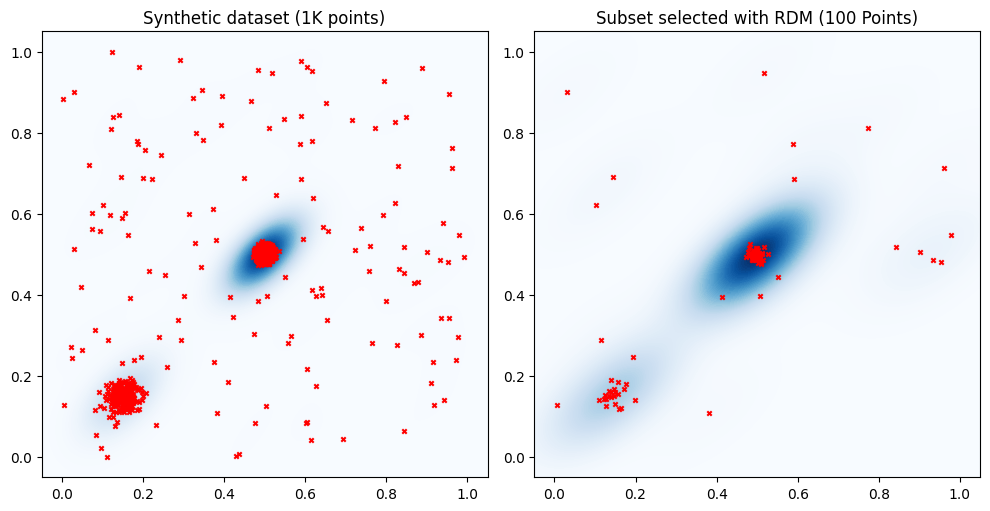

In [4]:


# Select a subset uniformly at random
subset_size = 100
subset_indices = np.random.choice(len(dataset), size=subset_size, replace=False)

# Plot KDE and points
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Titles for the plots
titles = ['Synthetic dataset (1K points)', 'Subset selected with RDM (100 Points)']

# Data for the plots
data = [(dataset[:, 0], dataset[:, 1]), (dataset[subset_indices, 0], dataset[subset_indices, 1])]

# Plotting
for ax, (x, y), title in zip(axes, data, titles):
    sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap="Blues", thresh=0, levels=100)
    ax.scatter(x, y, color='red', s=10, marker='x')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

plt.tight_layout()
plt.show()

The figure illustrates that while RDM may be uniform over the dataset, it might not be uniform across the data space (the unit square in this example). If points in a dataset cluster around specific locations, a randomly sampled subset may not include points in areas with lower data density, such as the lower-right quadrant of the unit square. This can lead to a lack of **representativeness** of the data space and **diversity** of the selected samples in the sampled subset.

**Representativeness** refers to the extent to which a sample accurately reflects the distribution of the entire dataset. A representative sample ensures that all regions of the data space are proportionally included, providing a more accurate depiction of the overall dataset. In the above example the density distribution of the selected points resembles that of the whole dataset. However, some regions are clearly not considered in the selected set, e.g., lower-right quadrant.

**Diversity** refers to the extent to which a sample represents a wide range of different data points from the dataset. Ideally, a diverse subset consists of points from all regions of the data space (the unit square in our example). It it not required that the density distribution of the points in a diverse subset reflects that of the whole dataset.

# Diversity
One approach to ensure diversity of the selected sample is Farthest Point Sampling (FPS). FPS is a greedy algorithm that aims to maximize the coverage of the data space by sampling to maximize inter-point distances. In this example, we consider the Euclidean distance. An arbitrary distance or similarity function may be considered.

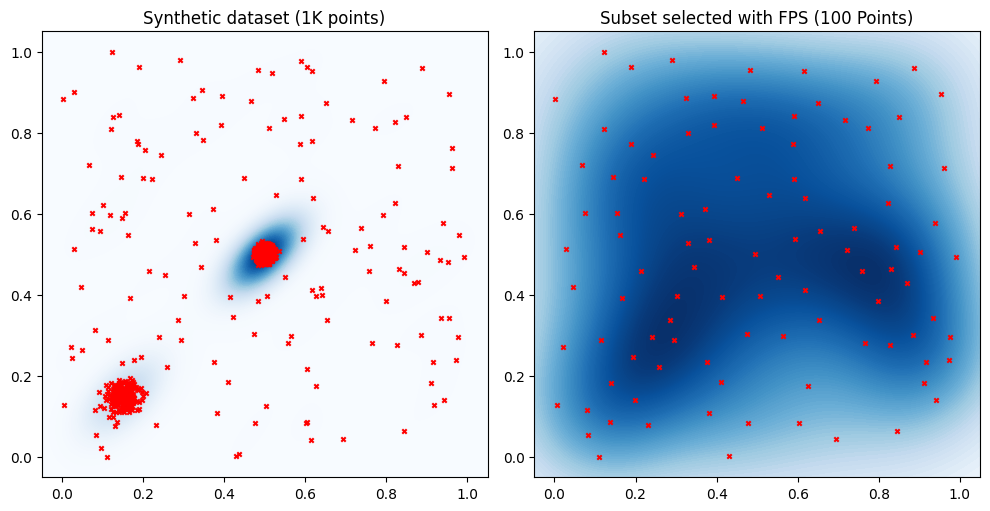

In [5]:
# Select a subset uniformly at random
initial_index = 0

fps_sampler = FPS(precomputed_distances= False)
fps_subset_indices = fps_sampler.fit(dataset, initial_subset=[initial_index], b_samples=subset_size)

# Plot all points and subset of points side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Titles for the plots
titles = ['Synthetic dataset (1K points)', 'Subset selected with FPS (100 Points)']

# Data for the plots
data = [(dataset[:, 0], dataset[:, 1]), (dataset[fps_subset_indices, 0], dataset[fps_subset_indices, 1])]

for ax, (x, y), title in zip(axes, data, titles):
    sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap="Blues", thresh=0, levels=100)
    ax.scatter(x, y, color='red', s=10, marker='x')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

plt.tight_layout()
plt.show()

 The plot on the right clearly shows that FPS selects a subset whose points are spread out the entire unit cube. In particular the selected subset does not tend to over or under-represent any region of the data space.

 # Representativeness
One approach to ensure representativeness of the selected sample is the Twin algorithm. Twin is a greedy algorithm that focuses on partitioning datasets into two statistically similar twin sets. The primary goal of this approach is to ensure that the dataset splits maintain statistical similarity. 

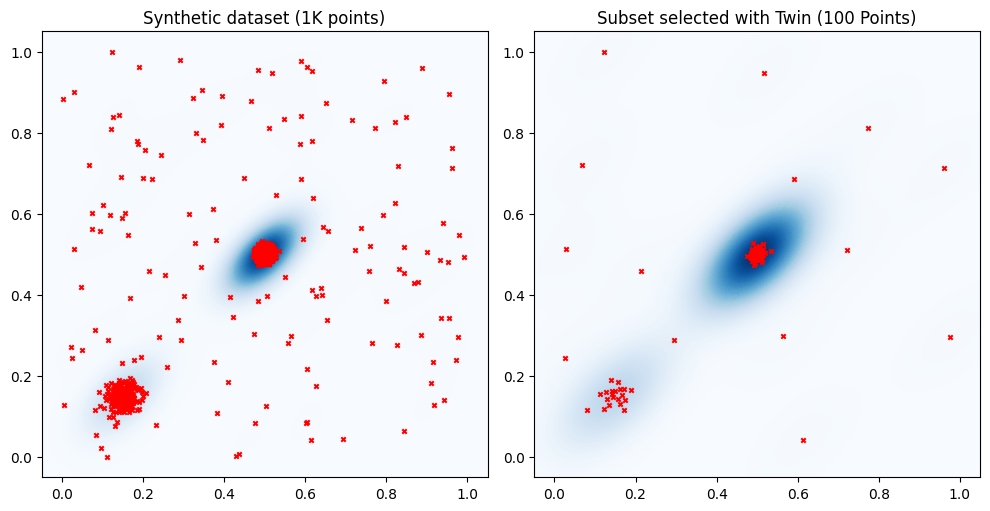

In [6]:
# Select a subset uniformly at random
initial_index = 0
twin_sampler = Twin(ratio=10, idx_initial_point=initial_index)
twin_subset_indices = twin_sampler.fit(dataset)
# Plot all points and subset of points side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Titles for the plots
titles = ['Synthetic dataset (1K points)', 'Subset selected with Twin (100 Points)']

# Data for the plots
data = [(dataset[:, 0], dataset[:, 1]), (dataset[twin_subset_indices, 0], dataset[twin_subset_indices, 1])]

# Plotting
for ax, (x, y), title in zip(axes, data, titles):
    sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap="Blues", thresh=0, levels=100)
    ax.scatter(x, y, color='red', s=10, marker='x')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

plt.tight_layout()
plt.show()

The plot on the right shows that the subset selected with the Twin algorithm captures the density distribution of the points in the training set, similar to RDM. However, unlike RDM, Twin is less likely to overlook regions of the data space with lower data density. For instance, in the above example, Twin selects at least one point from each quadrant of the unit cube. Moreover, looking at the cluster in the lower-left corner, we can see that the points selected with Twin are more omogenuosly distributed than those selected with RDM. This is because the data selection strategy implemented by the Twin algorithm tends to avoid selecting data points that are too close to each other.

# Balancing between diversity and representativeness
One approach that can be used to balance diversity and representativeness of the selected samples is Density Aware Farthest Point Sampling (DAFPS). DAFPS is modification of the FPS that considers weighted distances, where the weight provide information on the data density. DAFPS balances the representation of both dense and sparse regions  of the data space. 

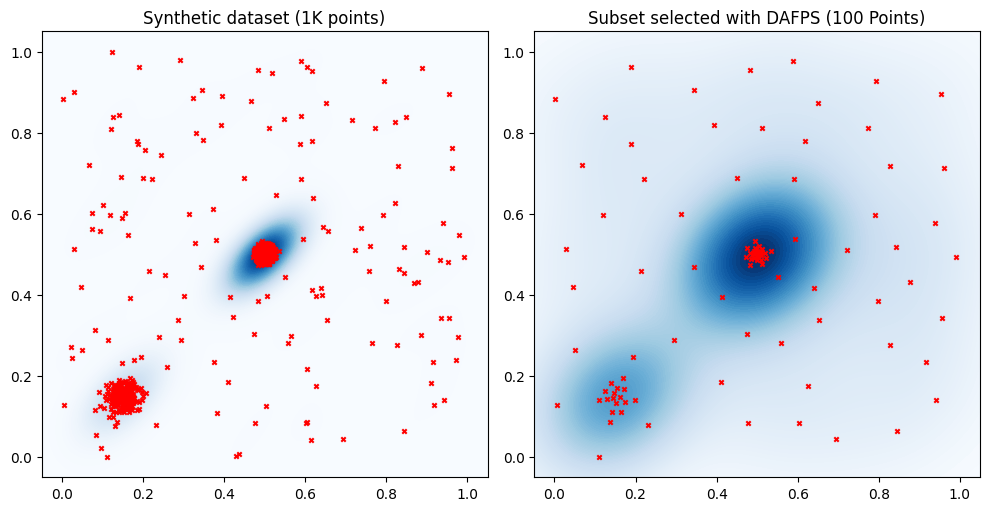

In [7]:
# Select a subset uniformly at random
initial_index = 0
fps_sampler = DAFPS(dataset,precomputed_distances= False)
fps_subset_indices = fps_sampler.fit(initial_subset=[initial_index], b_samples=subset_size, mu=0)

# Plot all points and subset of points side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Titles for the plots
titles = ['Synthetic dataset (1K points)', 'Subset selected with DAFPS (100 Points)']

# Data for the plots
data = [(dataset[:, 0], dataset[:, 1]), (dataset[fps_subset_indices, 0], dataset[fps_subset_indices, 1])]

# Plotting
for ax, (x, y), title in zip(axes, data, titles):
    sns.kdeplot(x=x, y=y, ax=ax, fill=True, cmap="Blues", thresh=0, levels=100)
    ax.scatter(x, y, color='red', s=10, marker='x')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)

plt.tight_layout()
plt.show()

 The plots show that the include in the selected set points from  all regions. The distribution of the points selected with DAFPS resembles that of the full dataset. Still, the differences in density across regions are less pronounced than in the true data distribution. In contrast, FPS consistently selects points to provide a uniform representation of the data distribution, while RDM and Twin mainly focus selecting subsets that more closely resemble the data distribution of the whole dataset.
